In [1]:
import sys
print(sys.executable)
MYAPIKEY = 'YOUR_API_KEY'
seed = 42
eval_period = 15
companies = ["FB", "AMZN", "AAPL", "NFLX", "GOOGL", "MSFT", "BA"]
symbol = companies[1]
print(symbol)

C:\Users\PC\anaconda3\envs\dsa5101\python.exe
AMZN


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries 
from sklearn.model_selection import train_test_split

In [3]:
config = {
    "alpha_vantage": {
        "key": "{}".format(MYAPIKEY),
        "symbol": symbol,
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
        "data_points" : 1000,
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

Number data points: 1000 from 2017-09-29 to 2021-09-20


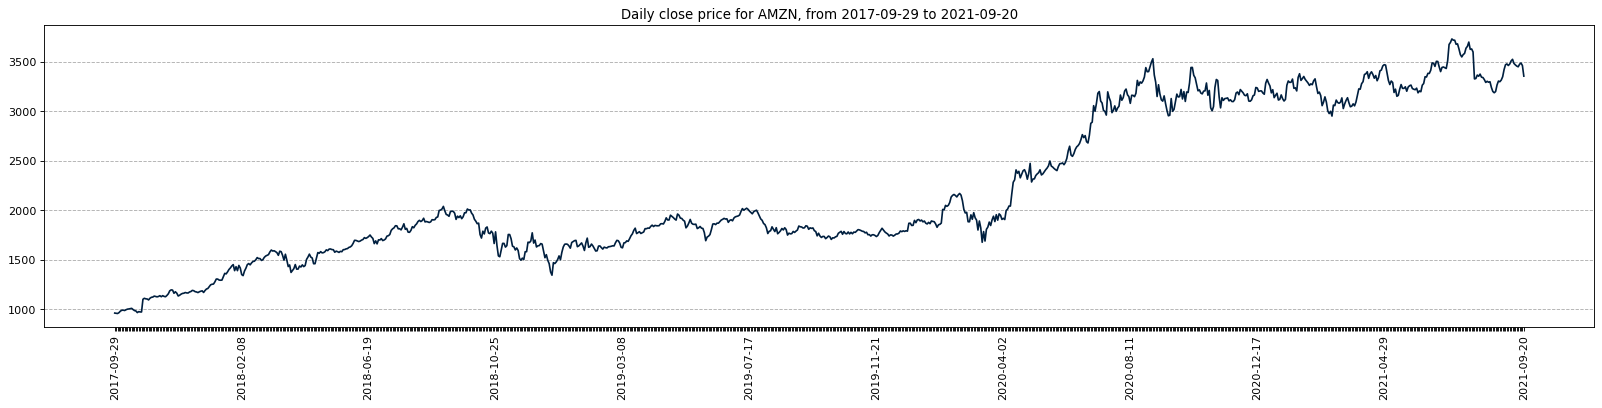

In [4]:
def download_data(config, plot=False):
    # get the data from alpha vantage

    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    # take last 500 days
    num = config["alpha_vantage"]["data_points"]
    data_date = data_date[-num:]
    data_close_price = data_close_price[-num:]

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config, plot=config["plots"]["show_plots"])

In [5]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

In [6]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])
    
    # split test period
    test_x = data_x[-eval_period:]
    test_y = data_y[-eval_period:]
    data_x = data_x[:-eval_period]
    data_y = data_y[:-eval_period]

    # split dataset
    data_x_train, data_x_val, data_y_train, data_y_val = train_test_split(data_x, data_y, test_size=1-config["data"]["train_split_size"], random_state=seed)

    return data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen, test_x, test_y

data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen, test_x, test_y = prepare_data(normalized_data_close_price, config, plot=config["plots"]["show_plots"])

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)
dataset_test = TimeSeriesDataset(test_x, test_y)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)

Train data shape (772, 20, 1) (772,)
Validation data shape (193, 20, 1) (193,)
Test data shape (15, 20, 1) (15,)


In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

In [9]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))


Epoch[1/100] | loss train:0.047346, test:0.030852 | lr:0.010000
Epoch[2/100] | loss train:0.007161, test:0.007388 | lr:0.010000
Epoch[3/100] | loss train:0.020856, test:0.006087 | lr:0.010000
Epoch[4/100] | loss train:0.009069, test:0.013565 | lr:0.010000
Epoch[5/100] | loss train:0.010209, test:0.000610 | lr:0.010000
Epoch[6/100] | loss train:0.004031, test:0.000327 | lr:0.010000
Epoch[7/100] | loss train:0.002780, test:0.016629 | lr:0.010000
Epoch[8/100] | loss train:0.003114, test:0.025236 | lr:0.010000
Epoch[9/100] | loss train:0.003537, test:0.000373 | lr:0.010000
Epoch[10/100] | loss train:0.007088, test:0.051133 | lr:0.010000
Epoch[11/100] | loss train:0.003461, test:0.004588 | lr:0.010000
Epoch[12/100] | loss train:0.003530, test:0.001480 | lr:0.010000
Epoch[13/100] | loss train:0.009754, test:0.005639 | lr:0.010000
Epoch[14/100] | loss train:0.004042, test:0.007166 | lr:0.010000
Epoch[15/100] | loss train:0.006164, test:0.003651 | lr:0.010000
Epoch[16/100] | loss train:0.00439

In [10]:
def new_x(last_20_days, new_price):
    last_20_list = last_20_days.squeeze().tolist()
    new_x = last_20_list[1:] + [new_price]
    return torch.tensor(new_x).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2)

In [11]:
model.eval()

predicted_future = []
x = torch.tensor(test_x[0]).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2)
for i in range(len(test_x)):
    prediction = model(x)
    prediction = prediction.cpu().detach().numpy()[0]
    predicted_future.append(prediction)
    x = new_x(x, prediction)

predicted_future = scaler.inverse_transform(predicted_future)
actual_future = scaler.inverse_transform(test_y)

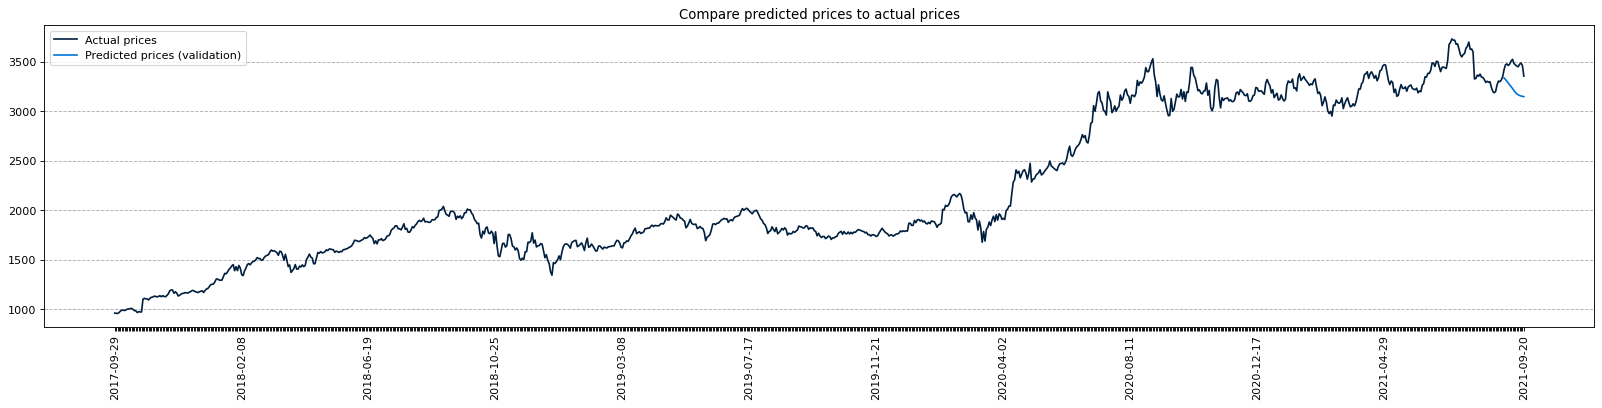

In [12]:
if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices
    to_plot_data_y_test_pred = np.zeros(num_data_points)
    to_plot_data_y_test_pred[-eval_period:] = predicted_future
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plots
    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_test_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])

    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

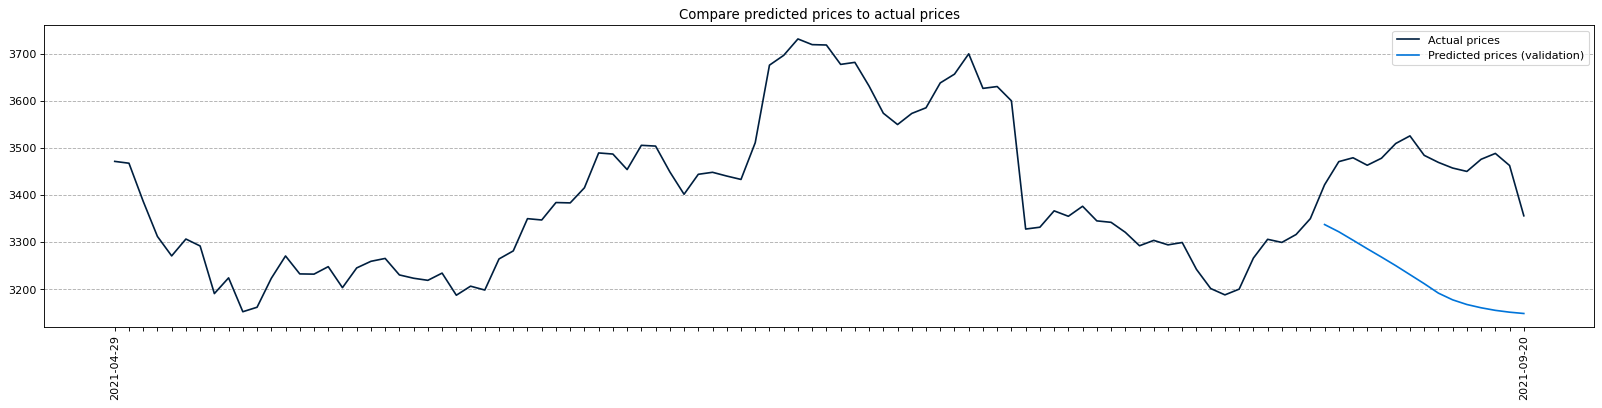

In [13]:
if config["plots"]["show_plots"]:
    plot_date = 100

    # prepare data for plotting, show predicted prices
    to_plot_data_y_test_pred = np.zeros(plot_date)
    to_plot_data_y_test_pred[-eval_period:] = predicted_future
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plots
    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date[-plot_date:], data_close_price[-plot_date:], label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date[-plot_date:], to_plot_data_y_test_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])

    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[-plot_date:][i] if ((i%config["plots"]["xticks_interval"]==0 and (plot_date-i) > config["plots"]["xticks_interval"]) or i==plot_date-1) else None for i in range(plot_date)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

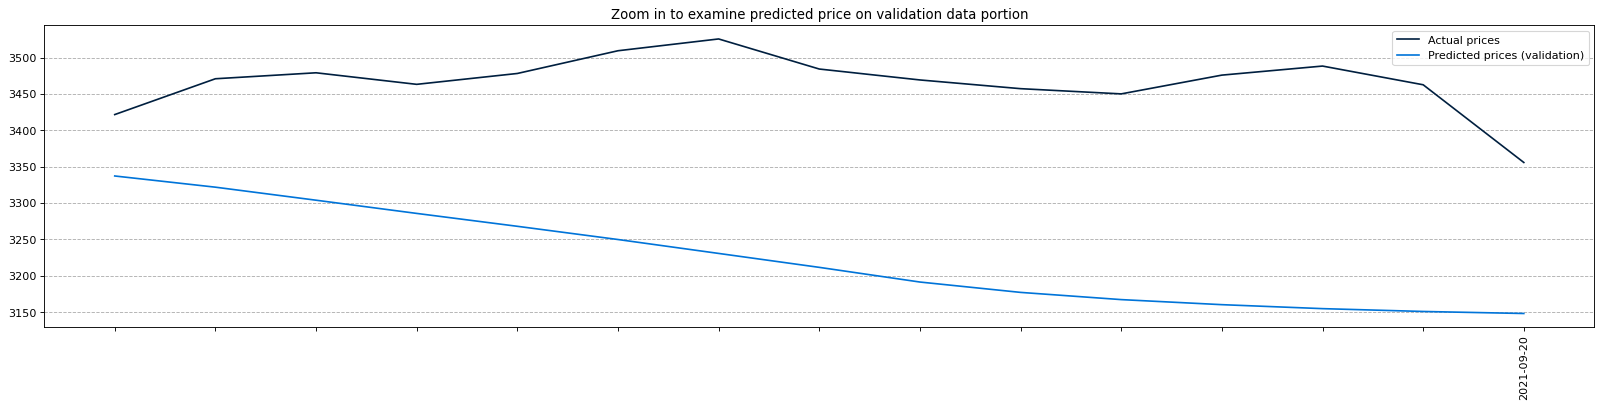

In [14]:
if config["plots"]["show_plots"]:    
    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = actual_future
    to_plot_predicted_test = predicted_future
    to_plot_data_date = data_date[-eval_period:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_test, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])

    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()